In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Union
from PIL import Image

In [2]:
def create_kernel_x(size: int) -> np.ndarray:
    kernel = np.zeros((size, size))
    for i in range(size//2):
        for j in range(size):
            kernel[i, j] = -1
    for i in range(size//2 + 1, size):
        for j in range(size):
            kernel[i, j] = 1
    return kernel

def create_kernel_y(size: int) -> np.ndarray:
    kernel = np.zeros((size, size))
    for j in range(size//2):
        for i in range(size):
            kernel[i, j] = -1
    
    for j in range(size//2 + 1, size):
        for i in range(size):
            kernel[i, j] = 1
    return kernel


In [3]:
create_kernel_x(7)

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [4]:
kernel_y = create_kernel_y(7)
kernel_y.dtype, kernel_y

(dtype('float64'),
 array([[-1., -1., -1.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  1.,  1.,  1.],
        [-1., -1., -1.,  0.,  1.,  1.,  1.]]))

In [5]:
def mag(x: np.ndarray, y: np.ndarray, n: int) -> np.ndarray:
    return np.sqrt(x**2 + y**2)/(n**2)

def convolution(kernel: np.ndarray, img: np.ndarray) -> np.ndarray:
    n = kernel.shape[0]
    m, z = img.shape
    # new_img = np.zeros((m-n+1, z-n+1), dtype=np.float64)
    new_img = np.zeros((m, z), dtype=np.float64)
    mid_kernel = n//2
    for i in range(mid_kernel, m-mid_kernel):
        for j in range(mid_kernel, z-mid_kernel):
            new_img[i, j] = np.sum(kernel * img[i-mid_kernel:i+mid_kernel+1, j-mid_kernel:j+mid_kernel+1])
            # curr_sum = 0
            # for k in range(n):
            #     for l in range(n):
            #         curr_sum += kernel[k, l] * img[i+k, j+l]
            # new_img[i, j] = curr_sum
    return new_img

def pad_with_zeros(convoluted_img: np.ndarray, orig_img_shape: Tuple[int,int], n: int) -> np.ndarray:
    new_img = np.zeros(orig_img_shape, dtype=np.float64)
    for i in range(n//2, orig_img_shape[0] - n//2):
        for j in range(n//2, orig_img_shape[1] - n//2):
            new_img[i, j] = convoluted_img[i - n//2, j - n//2]
    return new_img

def assigning_maximum_grad_per_pixel(M: np.ndarray, S: np.ndarray, curr_mag: np.ndarray, t: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if curr_mag[i, j] > t:
                M[i, j] = curr_mag[i, j]
                S[i, j] = n
    return M, S

def main(I: np.ndarray, s: int, t: int) -> np.ndarray:
    all_mags = []
    for n in range(3, s+1, 2):
        kernel_x = create_kernel_x(n)
        kernel_y = create_kernel_y(n)
        Gx = convolution(kernel_x, I)
        Gy = convolution(kernel_y, I)
        Mag = mag(Gx, Gy, n)
        # Mag_padded = pad_with_zeros(Mag, I.shape, n)
        all_mags.append(Mag)
        
    M = np.zeros(I.shape, dtype=np.float64)
    S = np.zeros(I.shape, dtype=int)
    for Mag in all_mags:
        M, S = assigning_maximum_grad_per_pixel(M, S, Mag, t, n)
    return M, S



In [6]:
kernel_x = create_kernel_x(3)
x = np.random.randint(0, 255, (5, 5))
convolution(kernel_x, x) 

array([[   0.,    0.,    0.,    0.,    0.],
       [   0.,  -35.,  143.,  -89.,    0.],
       [   0., -346.,  -53.,   62.,    0.],
       [   0.,  106.,   16.,  269.,    0.],
       [   0.,    0.,    0.,    0.,    0.]])

In [7]:
def read_image(path: str, grayscale: bool = True) -> np.ndarray:
    """
    Reads an image from the specified path and converts it to a NumPy array.
    
    Parameters:
    - path (str): The file path to the image.
    - grayscale (bool): If True, converts the image to grayscale.
    
    Returns:
    - np.ndarray: The image as a NumPy array.
    """
    img = Image.open(path)
    
    if grayscale:
        img = img.convert('L')
    
    img = np.array(img, dtype=np.uint8)
    
    return img

In [8]:
def plot_imgs_beside_each_other(img1: np.ndarray, M: np.ndarray,  S: np.ndarray, title1: str, title2: str, title3: str):
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title(title1)
    axs[0].axis('off')
    axs[1].imshow(M, cmap='gray')
    axs[1].set_title(title2)
    axs[1].axis('off')
    axs[2].imshow(S, cmap='gray')
    axs[2].set_title(title3)
    axs[2].axis('off')
    plt.show()

def test_img(img_path: str, s: int, t: int) -> Tuple[np.ndarray, np.ndarray]:
    img = read_image(img_path)
    img = np.array(img, dtype=np.float64)
    M, S = main(img, s, t)
    plot_imgs_beside_each_other(img, M, S, 'Original Image', 'Edge Detected Image', 'Kernel Size Map')
    return M, S


## Threshold=10

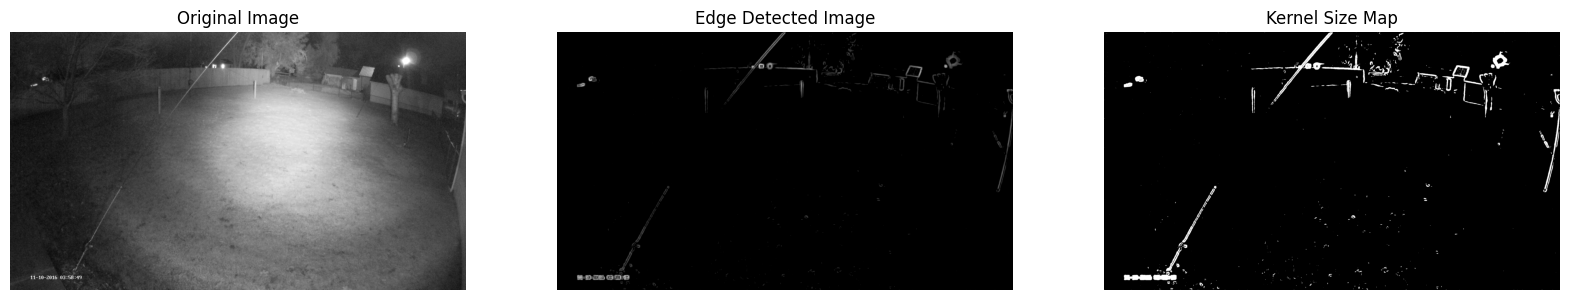

In [87]:
M, S = test_img('./test1.png', 13, 10)

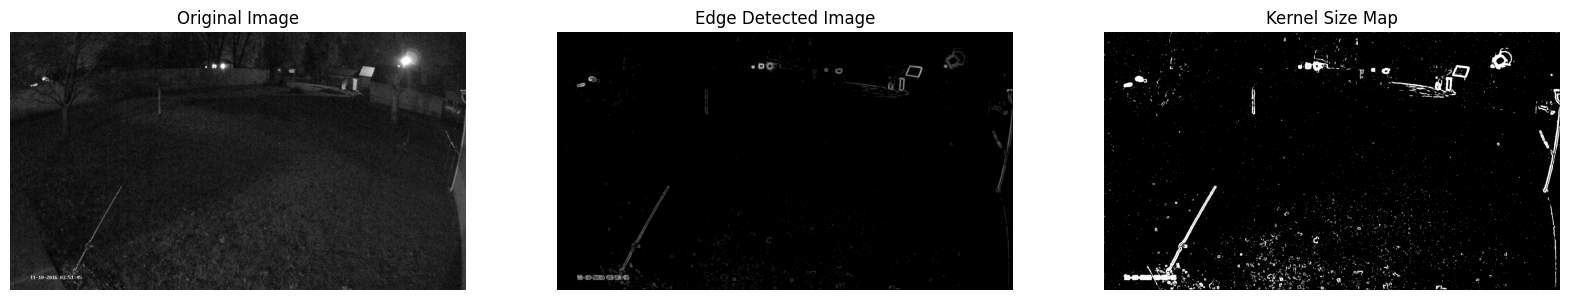

In [88]:
M, S = test_img('./test2.png', 13, 10)

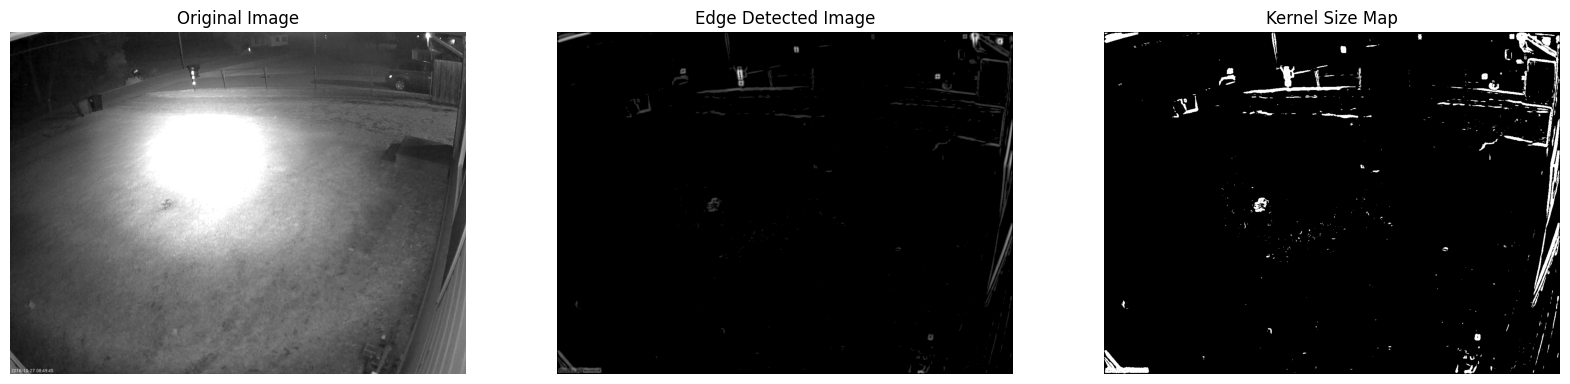

In [89]:
M, S = test_img('./test3.png', 13, 10)

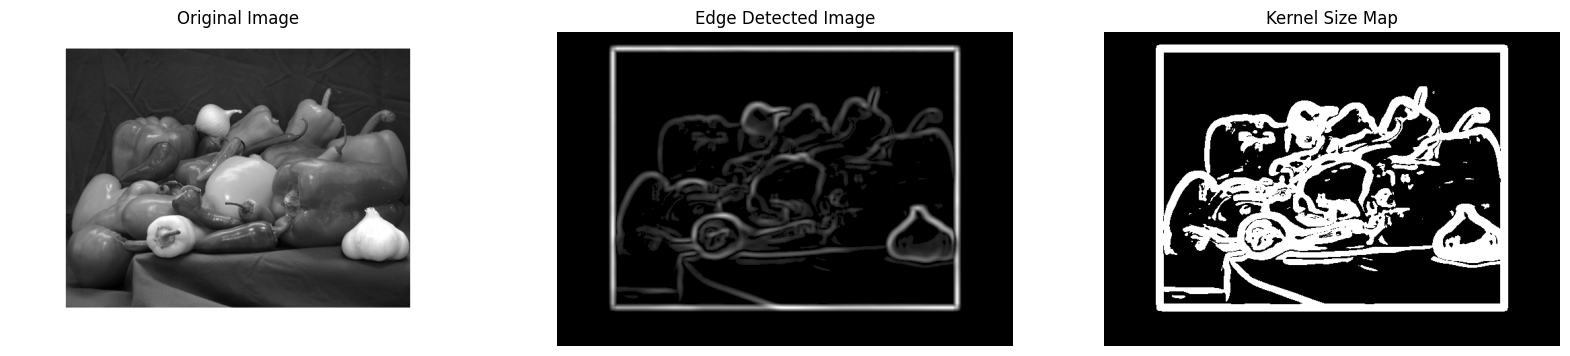

In [90]:
M, S = test_img('./test4.png', 13, 10)

## Threshold=20

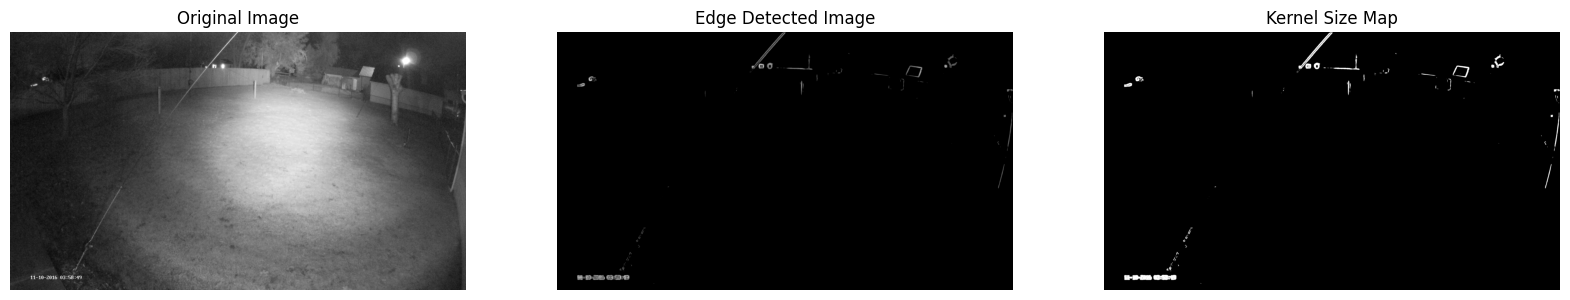

In [12]:
M, S = test_img('./test1.png', 13, 20)

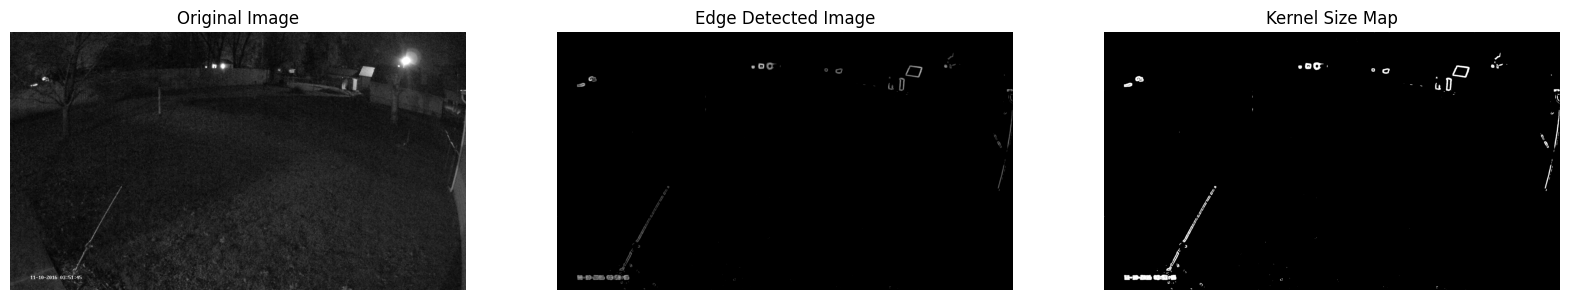

In [11]:
M, S = test_img('./test2.png', 13, 20)

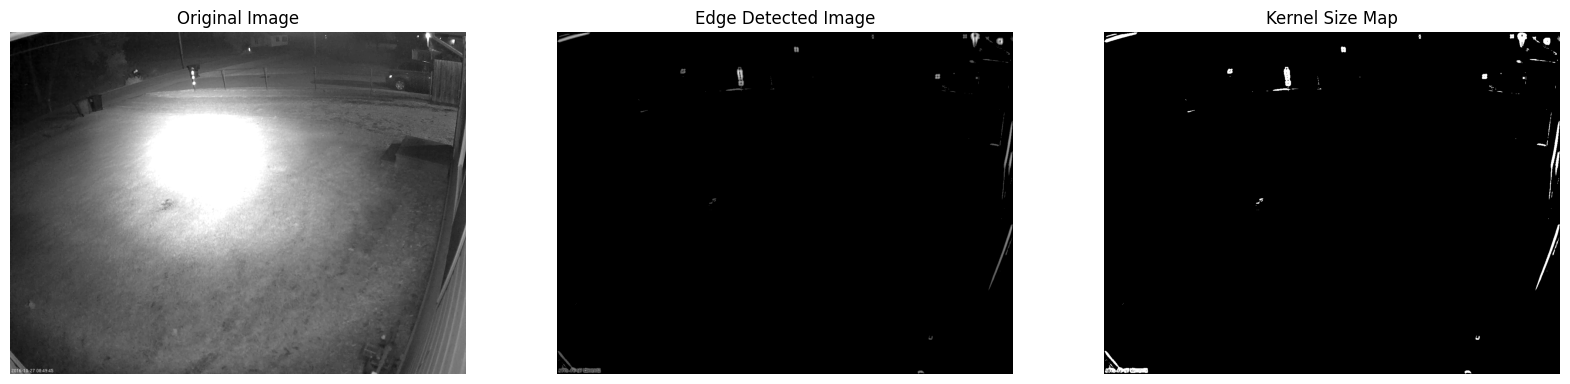

In [10]:
M, S = test_img('./test3.png', 13, 20)

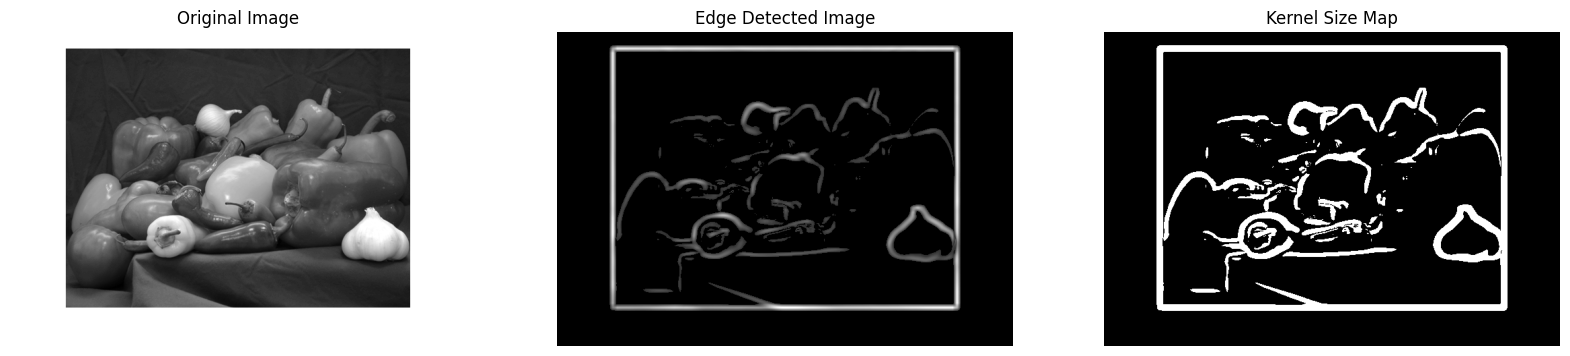

In [9]:
M, S = test_img('./test4.png', 13, 20)